In [ ]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;

# you HAVE to upload a number of files and folders used in the code
# problem.py - utils.py - data files inside directory named data
# upload them in the home directory --- don't go into any folder, just press upload button
# and choose these files and folders
# so tthe directory should be 
#|- data/       |- graph.html
#|              |- route.html 
#|- sample_data/ 
#|- problem.py
#|- utils.py

# Explanation and Discussion to be done

In [108]:
import osmnx as ox
import networkx as nx
from IPython.display import IFrame, HTML
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import sys, random
from problem import *
from utils import *
from itertools import filterfalse, chain

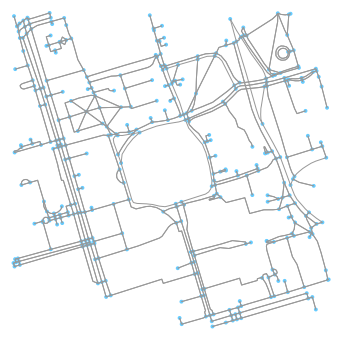

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

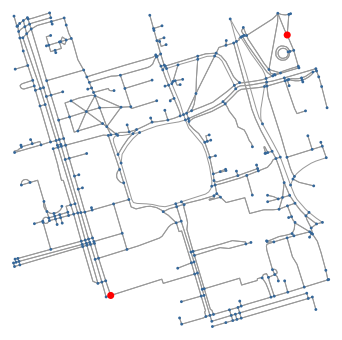

In [3]:
# marking both the source and destination node

nc = ['r' if node == 389677909 or node == 55808290 else '#336699' for node in G.nodes()]
ns = [50 if node == 389677909 or node == 55808290 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
%%capture
source(Node)

In [5]:
def random_routes(G, source, destination, nums_of_paths = 1):
    origin = Node(graph = G, node = G[source], osmid = source, distance = 0, parent = None)
    destination = Node(graph = G, node = G[destination], osmid = destination)
    nums = nums_of_paths
    routes = list()
    while nums > 0:
        route = []
        frontier = deque([origin])
        explored = set()
        found = False
        while frontier and not found:
            node = random.choice(frontier)   # here is the randomization part
            frontier.remove(node)
            explored.add(node)
            for child in node.expand():
                if child not in explored and child not in frontier:
                    if child == destination:
                        route, cost = child.path()
                        routes.append((route, cost))
                        found = True
                    frontier.append(child)
        nums -= 1
    return routes

In [6]:
origin = Node(graph = G, node = G[55808290], osmid = 55808290, distance = 0, parent = None)
destination = Node(graph = G, node = G[389677909], osmid = 389677909)

In [7]:
# this is more or less the same as the genetic search algorithm
# but here we make sure to get the right solution
def merge(p1, p2):
    intersection = [*filterfalse(lambda element : element in [origin.osmid, destination.osmid] , list(set(p1) & set(p2)))]
    if len(intersection) == 0: return p1
    cross_over_point = random.choice(intersection)
    first_point = p1.index(cross_over_point)
    second_point = p2.index(cross_over_point)
    if probability(0.5):
        return p1[:first_point] + p2[second_point:]
    else:
        return p2[:second_point] + p1[first_point:]

In [80]:
particles_swarm = 200

In [81]:
particles = random_routes(G, 55808290, 389677909, particles_swarm)

In [82]:
num_of_swarms = 4

In [83]:
num_of_iterations = 50

In [113]:
for iteration in range(num_of_iterations):
    # we need to have `num_of_swarms` particles to lead
    # a swarm and be its lbest ... that changes every iteration
    particles.sort(key = lambda particle : particle[1])
    swarm_particles = particles_swarm // num_of_swarms
    
    leaders = particles[:swarm_particles]
    
    for i in range(num_of_swarms):
        particles[i] , particles[i*(swarm_particles-1)] = particles[i*(swarm_particles-1)], particles[i]
    
    swarms = list()
    
    for i in range(num_of_swarms):
        swarms.append(particles[i*(swarm_particles): i*(swarm_particles) + swarm_particles])
    
    # for each swarm follow the leader of the swarm
    def follow_leader_local(population):
        for i in range(1, len(population)):
            ## packing and unpacking and all that to deal with
            ## the immutability of tuples in python
            population[i] = [*population[i]]
            population[i][0] = merge(population[0][0], population[i][0]) # this is what we are doing
            population[i] = tuple(population[i])
            
    for swarm in swarms:
        follow_leader_local(swarm)
    
    def follow_leader_global():
        for i in range(1, len(leaders)):
            leaders[i] = [*leaders[i]]
            leaders[i][0] = merge(leaders[0][0], leaders[i][0])
            leaders[i] = tuple(leaders[i])
    
    follow_leader_global()
    
    particles = list(chain.from_iterable(swarms))
    
    # adding the new leaders
    
    for i in range(num_of_swarms):
        particles[i*(swarm_particles - 1)] = leaders[i]

In [126]:
route, cost = min(particles, key = lambda particle : particle[1])

In [127]:
route

[55808290,
 304891685,
 55808284,
 1721866234,
 389678268,
 4953810915,
 389678267,
 24960090,
 389678273,
 1258698113,
 389678151,
 389678142,
 2143489694,
 389678141,
 2143488528,
 389678140,
 389678139,
 389678138,
 3707407638,
 6028561924,
 5098988924,
 389678131,
 6028562356,
 389677908,
 749952029,
 389677909]

In [128]:
cost

818.3259999999998

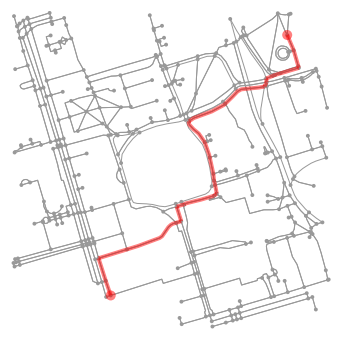

In [125]:
fig, ax = ox.plot_graph_route(G, route)